In [1]:
import data as D
import train as T

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
#Hyperparameters
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


#x = torch.randn(1, 5*1, 424, 512)#[batch_size, sequence_len*channels, height, width]

trainset =  D.BaxterJointsSynthDataset("./data/dataset", [0], "train", demo = False, img_size=(512, 424), sequence_length=1, norm_type="min_max")
trainset.train()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=8,
                                        drop_last=True)


valset =  D.BaxterJointsSynthDataset("./data/dataset", [0], "train", demo = False, img_size=(512, 424), sequence_length=1, norm_type="min_max")
valset.eval()
valloader =  torch.utils.data.DataLoader(valset, batch_size=4,
                                    shuffle=False, num_workers=8,
                                    drop_last=True)

Loading val set run 0: 100%|██████████| 1908/1908 [00:00<00:00, 60366.54it/s]


In [32]:
len(trainset)


28

In [36]:
valset[2]


{'depth8': tensor([[[[-1.2714, -1.2714, -1.2714,  ..., -1.2714, -1.2714, -1.2714],
           [-1.2714, -1.2714, -1.2714,  ..., -1.2714, -1.2714, -1.2714],
           [-1.2714, -1.2714, -1.2714,  ..., -1.2714, -1.2714, -1.2714],
           ...,
           [-1.2714, -1.2714, -1.2714,  ..., -1.2714, -1.2714, -1.2714],
           [-1.2714, -1.2714, -1.2714,  ..., -1.2714, -1.2714, -1.2714],
           [-1.2714, -1.2714, -1.2714,  ..., -1.2714, -1.2714, -1.2714]]]])}

In [3]:

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 3 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        #x = F.sigmoid(self.t_conv2(x))
        x = self.t_conv2(x)
                
        return x

In [3]:
#Provare più profondi, meno canali 

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=1, stride=stride)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=1, stride=stride)
        self.actv = nn.ReLU()
        #self.actv = nn.Tanh()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.actv(x)
        x = self.conv2(x)
        x = self.actv(x)

        return x
    
class ConvTranspBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super().__init__()
        self.conv_tr1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, padding=1, stride=stride)
        self.conv_tr2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size, padding=1, stride=stride)
        #self.actv = nn.Tanh()
        self.actv = nn.ReLU()
    
    def forward(self, x):
        x = self.actv(x)
        x = self.conv_tr1(x)
        x = self.actv(x)
        x = self.conv_tr2(x)

        return x

#Encoder
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        #For the first convolution, we have input channels = 1. 32 and 3 are chosen arbitrarly for now
        self.conv1 = ConvBlock(1, 32, 3)#The input channels depend on the sequence length chosen
        self.conv2 = ConvBlock(32, 64, 3)
        self.conv3 = ConvBlock(64, 128, 3)
        self.pool = nn.MaxPool2d(3, stride=2, padding=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool(x)
        
        return x
        
#Decoder
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        """self.tcn1_tr = TCN_tr_v1(1024, 512, 3, 5)
        self.tcn2_tr = TCN_tr_v1(512, 256, 3, 4)"""
        self.conv_tr1 = ConvTranspBlock(128, 64, 3)
        self.conv_tr2 = ConvTranspBlock(64, 32, 3)
        self.conv_tr3 = ConvTranspBlock(32, 1, 3)

        self.upsample = nn.Upsample(scale_factor=2, mode="nearest")
        
    def forward(self, x):
        x = self.upsample(x)
        x = self.conv_tr1(x)
        x = self.conv_tr2(x)
        x = self.conv_tr3(x)
        return x
    
    #Autoencoder
class Autoencoder_conv(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.enc = encoder
        self.dec = decoder

        """self.conv2d1 = nn.Conv2d(256, 256, kernel_size = [2, 3], stride = [2, 2], padding = [7, 1])
        self.conv2d2 = nn.Conv2d(256, 256, kernel_size = [3, 3], stride = [2, 2], padding = [3, 1])
        self.conv1d = nn.Conv2d(256, 1, 1)
        self.conv1d_tr = nn.ConvTranspose2d(1, 256, 1)
        self.conv2d_tr1 = nn.ConvTranspose2d(256, 256, kernel_size = [4, 4], stride = [2, 2], padding = [3, 1])
        self.conv2d_tr2 = nn.ConvTranspose2d(256, 256, kernel_size = [2, 4], stride = [2, 2], padding = [7, 1])"""

        #self.actv = nn.Tanh()
        #self.actv = nn.ReLU()

    def encode(self, input_sequence):
        return self.enc(input_sequence)
    
    def decode(self, latent_vector):
        return self.dec(latent_vector)
    
    def forward(self, input_sequence):
        x = self.encode(input_sequence)
        ###
        """x = self.conv2d1(x)
        x = self.actv(x)
        x = self.conv2d2(x)
        x = self.actv(x)
        x = self.conv1d(x)
        x = self.actv(x)
        height, width = x.shape[2], x.shape[3] 
        latent_vector = x.flatten(1)
        x = latent_vector.unflatten(1, torch.Size([1, height, width]))
        x = self.conv1d_tr(x)
        x = self.actv(x)
        x = self.conv2d_tr1(x)
        x = self.actv(x)
        x = self.conv2d_tr2(x)"""
        ###
        out = self.decode(x)
        #Added the ReLU activation to have only positive values in the output
        #as we are dealing with the depth values
        return out, None#latent_vectorNon

In [8]:
model = None

In [16]:
model = ConvAutoencoder().to('cuda')

In [4]:
encoder = Encoder()
decoder = Decoder()
model = Autoencoder_conv(encoder, decoder).to(device)

In [5]:
import torch
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), 3*1e-3)
import numpy as np
for i in range(100):
    loss_ = []
    for input in trainloader:

        input = input["depth8"].to(device)
        input = input.reshape((input.shape[0], input.shape[1]*input.shape[2], input.shape[3], input.shape[4] ))

        output, _ = model(input)

        optimizer.zero_grad()
        loss = criterion(output, input[:, 0, :][:, None])

        loss.backward()
        optimizer.step()
        loss_.append(loss.item())

    print(f"{i} loss: {np.mean(loss_)}")




0 loss: 0.01791305063026292


KeyboardInterrupt: 

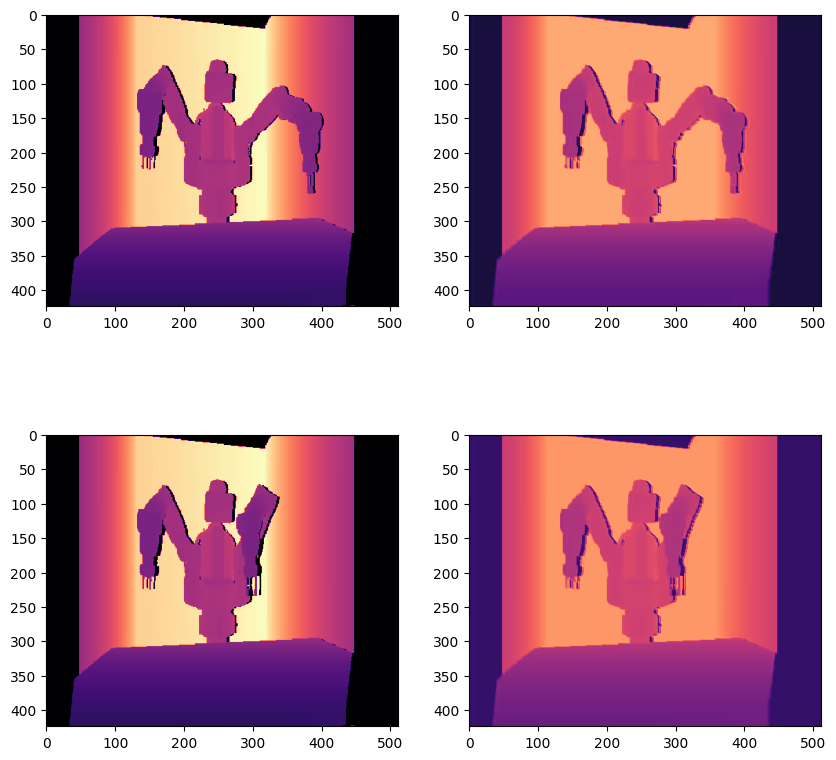

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

input = next(iter(valloader))

input = input['depth8'].squeeze()[:,None,:,:].to('cuda')

output, _ = model(input)

# Choose the desired colormap
colormap = 'magma'

# Plot each image in the corresponding position
axs[0, 0].imshow(input[0].squeeze().cpu().detach().numpy(), cmap='magma')
axs[0, 1].imshow(output[0].squeeze().cpu().detach().numpy(), cmap='magma')
axs[1, 0].imshow(input[1].squeeze().cpu().detach().numpy(), cmap='magma')
axs[1, 1].imshow(output[1].squeeze().cpu().detach().numpy(), cmap='magma')

plt.show()



In [ ]:
#TOCHECK I don't know if I have to do the XYZ transformation as said in the paper
encoder = M.Encoder()
decoder = M.Decoder()
model = M.Autoencoder_conv(encoder, decoder).to(device)

#I will test pdepth estimation first. To change the test for now, change the function call in the train function in train.py

criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), 3*1e-3)

T.evaluate_batch(model, valloader, criterion, device)